# Group 004 Real Estate Analysis

## Setup and Load Data

First, we retrieve the dataste from https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021.

If using the below cell, make sure you have a Kaggle API token in a `kaggle.json` file in `~/.kaggle/`. Otherwise, please download the data manually and place it under a folder `./data/`.

In [1]:
!mkdir data
!kaggle datasets download mrdaniilak/russia-real-estate-20182021
!mv ./russia-real-estate-20182021.zip ./data/russia-real-estate-20182021.zip

mkdir: data: File exists
 99%|███████████████████████████████████████▋| 110M/111M [00:19<00:00, 6.66MB/s]
100%|████████████████████████████████████████| 111M/111M [00:19<00:00, 5.95MB/s]


In [2]:
import zipfile
with zipfile.ZipFile('./data/russia-real-estate-20182021.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

Now, we may proceed with exploration.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_CSV_PATH = './data/all_v2.csv'

# load csv data
df = pd.read_csv(DATA_CSV_PATH)

# remove duplicate data
df = df.drop_duplicates()

In [5]:
df.sample(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
2068453,1950000,2019-06-26,06:27:34,55.019592,83.011150,9654,1,2,10,1,42.0,10.0,11
4114329,4800000,2020-07-20,06:10:47,52.252445,104.367980,5368,2,5,9,2,64.0,11.5,1
4720012,1239000,2020-11-16,20:59:42,53.467188,49.637446,3106,3,1,10,1,21.8,5.0,1
2399458,23566675,2019-08-16,08:42:21,55.775232,37.674002,3,2,5,10,2,78.1,20.0,11
3613095,1990000,2020-04-17,11:50:54,44.866639,37.334899,2843,2,3,9,2,32.0,6.0,1


Note that this Kaggle Dataset was originally pulled from GeoNames (http://www.geonames.org/), which has its own "regions" separated by county. Our city of interest, Moscow, has ID 81.

Addtionally, we will give categorical data appropriate labels given by the dataset spec.

In [6]:
MOSCOW_CODE = 81

moscow_df = df.loc[df['region'] == MOSCOW_CODE]
moscow_df = moscow_df.drop(['time', 'geo_lat', 'geo_lon', 'region'], axis=1)
moscow_df['date'] = moscow_df['date'].apply(lambda x: int(x[:4]))

moscow_df['object_type'] = moscow_df['object_type'].replace(1, 'preowned').replace(11, 'new')
moscow_df['building_type'] = moscow_df['building_type'].replace(0, 'other').replace(1, 'panel').replace(2, 'monolithic').replace(3, 'brick').replace(1, 'blocky').replace(5, 'wooden')

# -1 means studio apartment, so we replace with 0 (since studio apartments have no extra rooms)
# there are not other datapoints with value 0
moscow_df['rooms'] = moscow_df['rooms'].replace(-1, 0)

# remove rows with errorneous data
moscow_df = moscow_df[moscow_df['price'] >= 0]
moscow_df = moscow_df[moscow_df['rooms'] >= 0]

In [7]:
moscow_df.isnull().values.any()

False

In [8]:
moscow_df.sample(5)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type
2475499,6800000,2019,monolithic,17,17,3,74.1,12.2,preowned
4602492,5950000,2020,panel,4,9,2,52.0,9.0,preowned
1038320,1650000,2019,panel,4,5,1,31.0,6.0,preowned
4590821,4850000,2020,brick,5,5,3,55.3,6.0,preowned
5270982,4019900,2021,monolithic,3,11,2,65.9,16.6,new


# Exploration

First, we'll look at the data distributions for the ordinal data.

In [9]:
moscow_df.describe()

,price,date,level,levels,rooms,area,kitchen_area
count,5.001920e+05,500192.000000,500192.00000,500192.000000,500192.000000,500192.000000,500192.000000
mean,4.765453e+06,2019.310803,7.05152,12.741489,1.782240,51.734531,10.364580
std,4.208466e+06,0.880217,5.71243,7.391100,0.864063,25.727061,7.177274
min,0.000000e+00,2018.000000,1.00000,1.000000,0.000000,1.000000,0.050000
25%,3.000000e+06,2019.000000,3.00000,5.000000,1.000000,38.000000,7.000000
50%,4.300000e+06,2019.000000,5.00000,12.000000,2.000000,46.200000,9.600000
75%,5.950000e+06,2020.000000,10.00000,17.000000,2.000000,62.000000,12.000000
max,2.147484e+09,2021.000000,36.00000,39.000000,9.000000,5000.000000,3000.000000


Each column is skewed right, meaning we have some extreme outliers for each column. This is because in the real estate market, while most "normal" places have a similar price, the price ceiling for real estate can be very high. While these outliers are sparse, they could still bias our model.

Next, we can plot each variable against price to look for possible correlations. We will only looks at data points with price less than $2 \cdot 10^7$ to get better plots by removing price outliers.

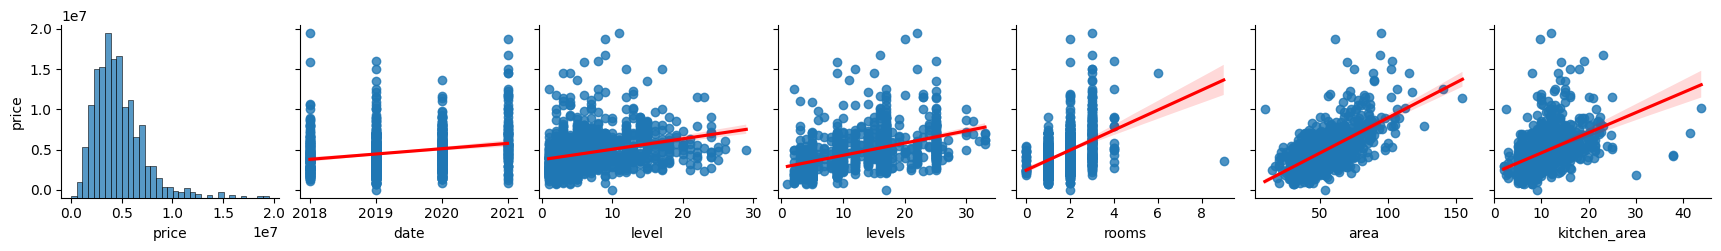

In [16]:
from scipy.stats import linregress

def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    slope, intercept, r_value, p_value, std_err = linregress(x=x, y=y)
    ax.annotate(f'$r^2 = {r_value ** 2:.2f}$\nEq: ${slope:.2f}x{intercept:+.2f}$',
                xy=(.05, .95), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')

g = sns.pairplot(moscow_df.loc[moscow_df['price'] < 2e7].sample(1000), y_vars=['price'], kind='reg', plot_kws={'line_kws':{'color':'red'}})

g.map_lower(r2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.show()

Each variable seems to have a weak 